<div style="text-align: center;">
    <h1> </font> <font color = #4854E8>Model Hyperparameter Tuning</h2> </font>
</div>

> Hyperparameter tuning is the technique of adjusting a machine learning model's hyperparameters in order to improve its performance and generalizability. According to the above model performance comparison, the LightGBM Regressor emerged as the most efficient and accurate model. 

---

In [1]:
%run ./Model_Hyperparameter_Tuning_utilities.ipynb

In [2]:
# Load resampled_data from the pickle file
resampled_data = load_from_pickle('resampled_data.pkl')

### Splitting the data into train and test sets 

The following function, takes the above resampled_data DataFrame as input. It first initializes a RandomState instance with a specific seed (42) to ensure reproducibility in the train-test split. Then, it splits the resampled_data into train and test sets using train_test_split function from scikit-learn, with the shuffle parameter set to False to prevent shuffling of data. Then, it defines the input and output columns for the model. The input columns include various features such as weather conditions, time-related information, and encoded categorical variables. The output column is "TotalDemand", representing the target variable.

After defining the input and output columns, it selects the corresponding data from the train and test sets, including the "Region" column which is used as a categorical variable. The selected input and output data for both train and test sets are then returned from the function.

In [3]:
# Create a RandomState instance with a specific seed
random_state = np.random.RandomState(seed=42)
    
# Train-test split without shuffling
train_data, test_data = train_test_split(resampled_data, shuffle=False, random_state=random_state)
    
 # Define input and output columns
input_columns = ['Month', 'Day', 'Hour','Precipitation', 'AirTemperature', 'WetBulbTemperature','DewTemperature','RelativeHumidity%','SeaPressure',
                 'StationPressure','WeekOfMonth', 'Quarter', 'DayOfYear', 'TemperatureDifference','PressureDifference','DayNightTempDifference',
                 'DayOfWeek_Friday', 'DayOfWeek_Monday', 'DayOfWeek_Saturday','DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday',
                 'DayOfWeek_Wednesday', 'Season_Autumn', 'Season_Spring','Season_Summer', 'Season_Winter','TimeOfDay_Afternoon','TimeOfDay_Evening',
                 'TimeOfDay_Morning', 'TimeOfDay_Night', 'IsWeekend_False', 'IsWeekend_True', 'TemperatureLevel_Cold', 'TemperatureLevel_Hot',
                 'TemperatureLevel_Mild', 'TemperatureLevel_Very Cold','TemperatureLevel_Warm', 'PrecipitationLevel_Heavy Precipitation',
                 'PrecipitationLevel_Light Precipitation','PrecipitationLevel_Moderate Precipitation','PrecipitationLevel_No Precipitation',
                 'PressureLevel_High Pressure','PressureLevel_Low Pressure','PressureLevel_Normal Pressure','HumidityLevel_High Moist',
                 'HumidityLevel_Low Moist','HumidityLevel_Moderate Moist'
                ]
output_columns = ["TotalDemand"]

# Select input and output data with "Region" for training data
train_input_data = train_data[input_columns + ["Region"]]
train_output_data = train_data[output_columns + ["Region"]]

# Select input and output data with "Region" for testing data
test_input_data = test_data[input_columns + ["Region"]]
test_output_data = test_data[output_columns + ["Region"]]

---

The process of fine-tuning the LightGBM regressor model begins with a two-stage optimization strategy. Initially, it performs a random search across a preset parameter grid using RandomizedSearchCV to efficiently explore hyperparameter combinations, yielding the best-performing hyperparameters (best_params_ran) and the corresponding best model (best_model). Following that, GridSearchCV executed a more focused grid search around these optimal parameters, reducing the search space to improve model performance and ultimately delivering a well-optimized LightGBM regressor model tailored to the dataset. Finally, the function returns the grid search object (grid), the best score (best_score), and the best parameters (best_params) achieved during grid search.

In [4]:
def get_best_model(test_input: pd.DataFrame, test_output: pd.DataFrame):
    
    # Define the parameter grid for random search
    random_param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
        'max_depth': [5, 6, 7, 8],
        'n_estimators': [200, 300, 400, 500],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'bagging_fraction': [0.7, 0.8, 0.9, 1.0],
        'min_child_samples': [5, 10, 20, 50, 100],
        'boosting_type': ['gbdt', 'dart', 'goss']
    }
    
    # Initialize the LightGBM Regressor model
    regressor = LGBMRegressor(random_state=42, verbose=-1, n_jobs=-1)
        
    # Perform random search
    random_search = RandomizedSearchCV(regressor, param_distributions=random_param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
    random_search.fit(test_input, test_output.values.ravel())
        
    # Get the best hyperparameters and the best model from random search
    best_params_ran = random_search.best_params_
    best_model = random_search.best_estimator_
        
    # Define the parameter grid for grid search using the best params from random search
    grid_param_grid = {
        'learning_rate': [best_params_ran['learning_rate']],
        'max_depth': [best_params_ran['max_depth'] - 1, best_params_ran['max_depth'], best_params_ran['max_depth'] + 1],
        'n_estimators': [best_params_ran['n_estimators'] - 50, best_params_ran['n_estimators'], best_params_ran['n_estimators'] + 50],
        'subsample': [best_params_ran['subsample']],
        'colsample_bytree': [best_params_ran['colsample_bytree']],
        'bagging_fraction': [best_params_ran['bagging_fraction']],
        'min_child_samples': [best_params_ran['min_child_samples']],
        'boosting_type': [best_params_ran['boosting_type']]
    }
    
    # Perform grid search
    grid = GridSearchCV(regressor, param_grid=grid_param_grid, n_jobs=-1)
    grid.fit(test_input, test_output.values.ravel())

    best_score = grid.best_score_
    best_params = grid.best_params_
    
    return grid, best_score, best_params      

The function then facilitates it to generate and organize predictions from the LightGBM regressor model. Initially, it uses the specified regressor to predict output values based on the test input data and then arranges these predictions and the corresponding input features into a structured data frame labelled test_results. If both training input and output are provided, the function can be extended to include predictions on the training data, resulting in a new data frame called train_results. 

In [5]:
def get_predictions(regressor, test_input, test_output, train_input=None, train_output=None):
    
    test_predictions = regressor.predict(test_input)
    test_results = pd.DataFrame(test_predictions, columns=output_columns, index=test_input.index)
    test_results = test_input.join(test_results)
    
    if train_input is not None and train_output is not None: 
        train_predictions = regressor.predict(train_input)
        train_results = pd.DataFrame(train_predictions, columns=output_columns, index=train_input.index)
        train_results = train_input.join(train_results)
        
        return test_results, train_results
    
    return test_results

The function then iterates through each region of the training dataset, performing cross-validation for each region in order to determine the optimal model parameters. These parameters are then used to train the model on training data specific to each region. During this process, the best model's performance score and corresponding parameters for each region are printed, assisting with model evaluation and parameter adjustment. Following model training, the algorithm collects the test data for the current region and implements the trained model to make predictions. These predictions are stored in two separate lists called test_predictions and train_predictions for the test and training datasets, respectively.

In [6]:
models, regressors = [], []

test_predictions, train_predictions = [], []

for region, dataframe in train_data.groupby("Region"):
    
    # Cross validate to find the best model
    model_input, model_output = dataframe.dropna()[input_columns], dataframe.dropna()[output_columns]
    grid, score, params = get_best_model(model_input, model_output)
    regressors.append(grid)
    models.append(regressors[-1].fit(model_input, model_output.values.ravel()))
    
    print(f"Best {region} model has a score of {score} and best params {params}")
    
    # Get the test data for this specific region
    test_input = test_data.groupby("Region").get_group(region)[input_columns].dropna()
    test_output = test_data.groupby("Region").get_group(region)[output_columns].dropna()
    
    # Generate predictions, obtain and log the final formatted data
    test_results, train_results = get_predictions(regressors[-1], test_input, test_output, model_input, model_output)
    test_predictions.append(test_results)
    train_predictions.append(train_results)

Best NSW model has a score of 0.8352422914500697 and best params {'bagging_fraction': 0.9, 'boosting_type': 'dart', 'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 8, 'min_child_samples': 5, 'n_estimators': 300, 'subsample': 0.9}
Best QLD model has a score of 0.8510769628857966 and best params {'bagging_fraction': 0.7, 'boosting_type': 'goss', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 20, 'n_estimators': 250, 'subsample': 1.0}
Best SA model has a score of 0.706452605287566 and best params {'bagging_fraction': 0.7, 'boosting_type': 'goss', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 20, 'n_estimators': 250, 'subsample': 1.0}
Best TAS model has a score of 0.7607055312163492 and best params {'bagging_fraction': 0.9, 'boosting_type': 'dart', 'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 8, 'min_child_samples': 5, 'n_estimators': 300, 'subsample': 0.9}
Best VIC model has a score o

In [7]:
# Save models and their parameters to a pickle file
with open("trained_model.pickle", "wb") as f:
    pickle.dump((models, [regressor.best_params_ for regressor in regressors]), f)

### Visualizing the performance


To visualize the performance of the above fine-tuned predictive model over different regions, each of the following snippets uses a subplot grid to accommodate data visualization for the weather parameters 'Wet Bulb Temperature' and 'Dew Point Temperature'


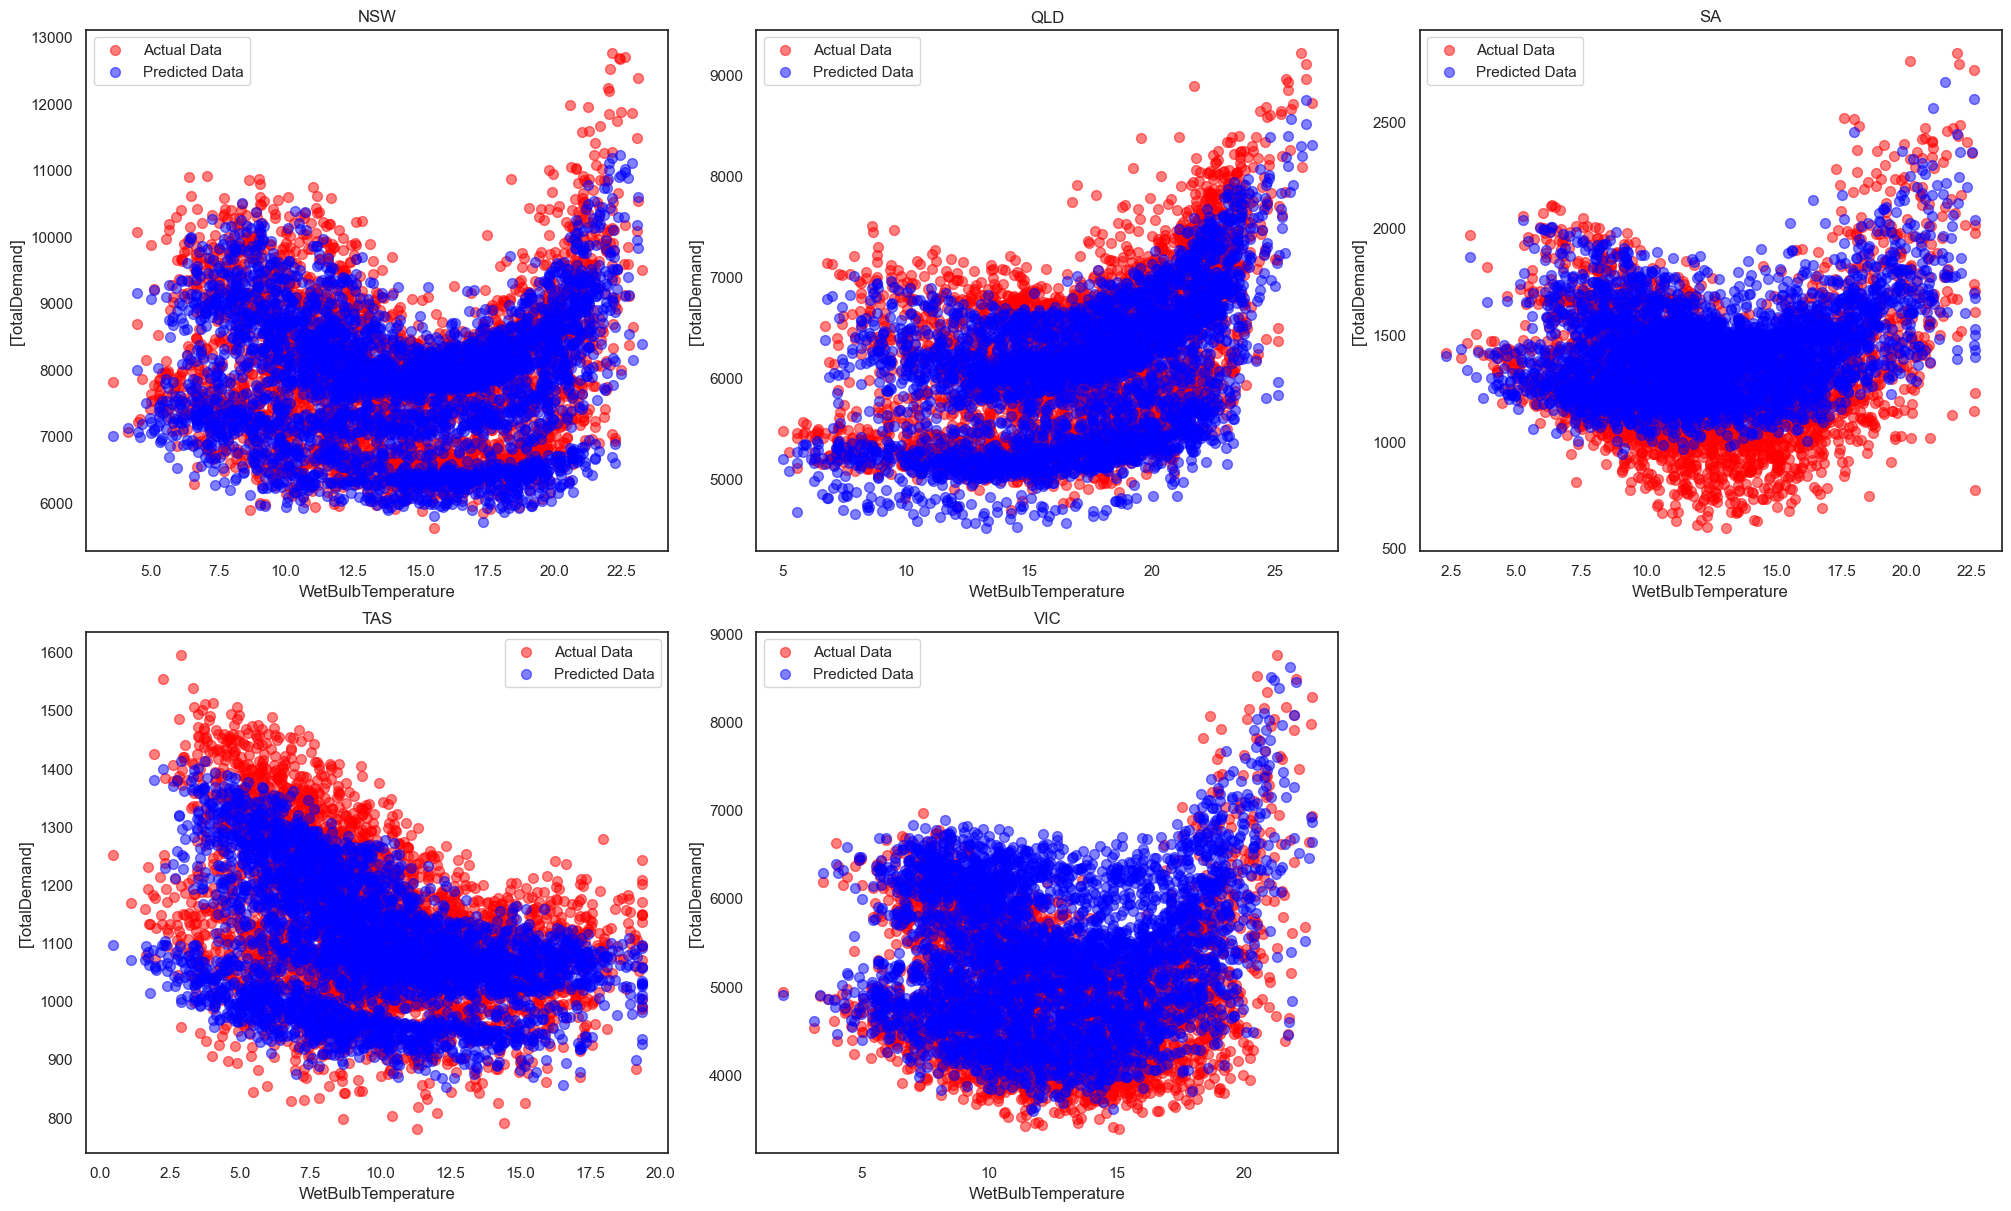

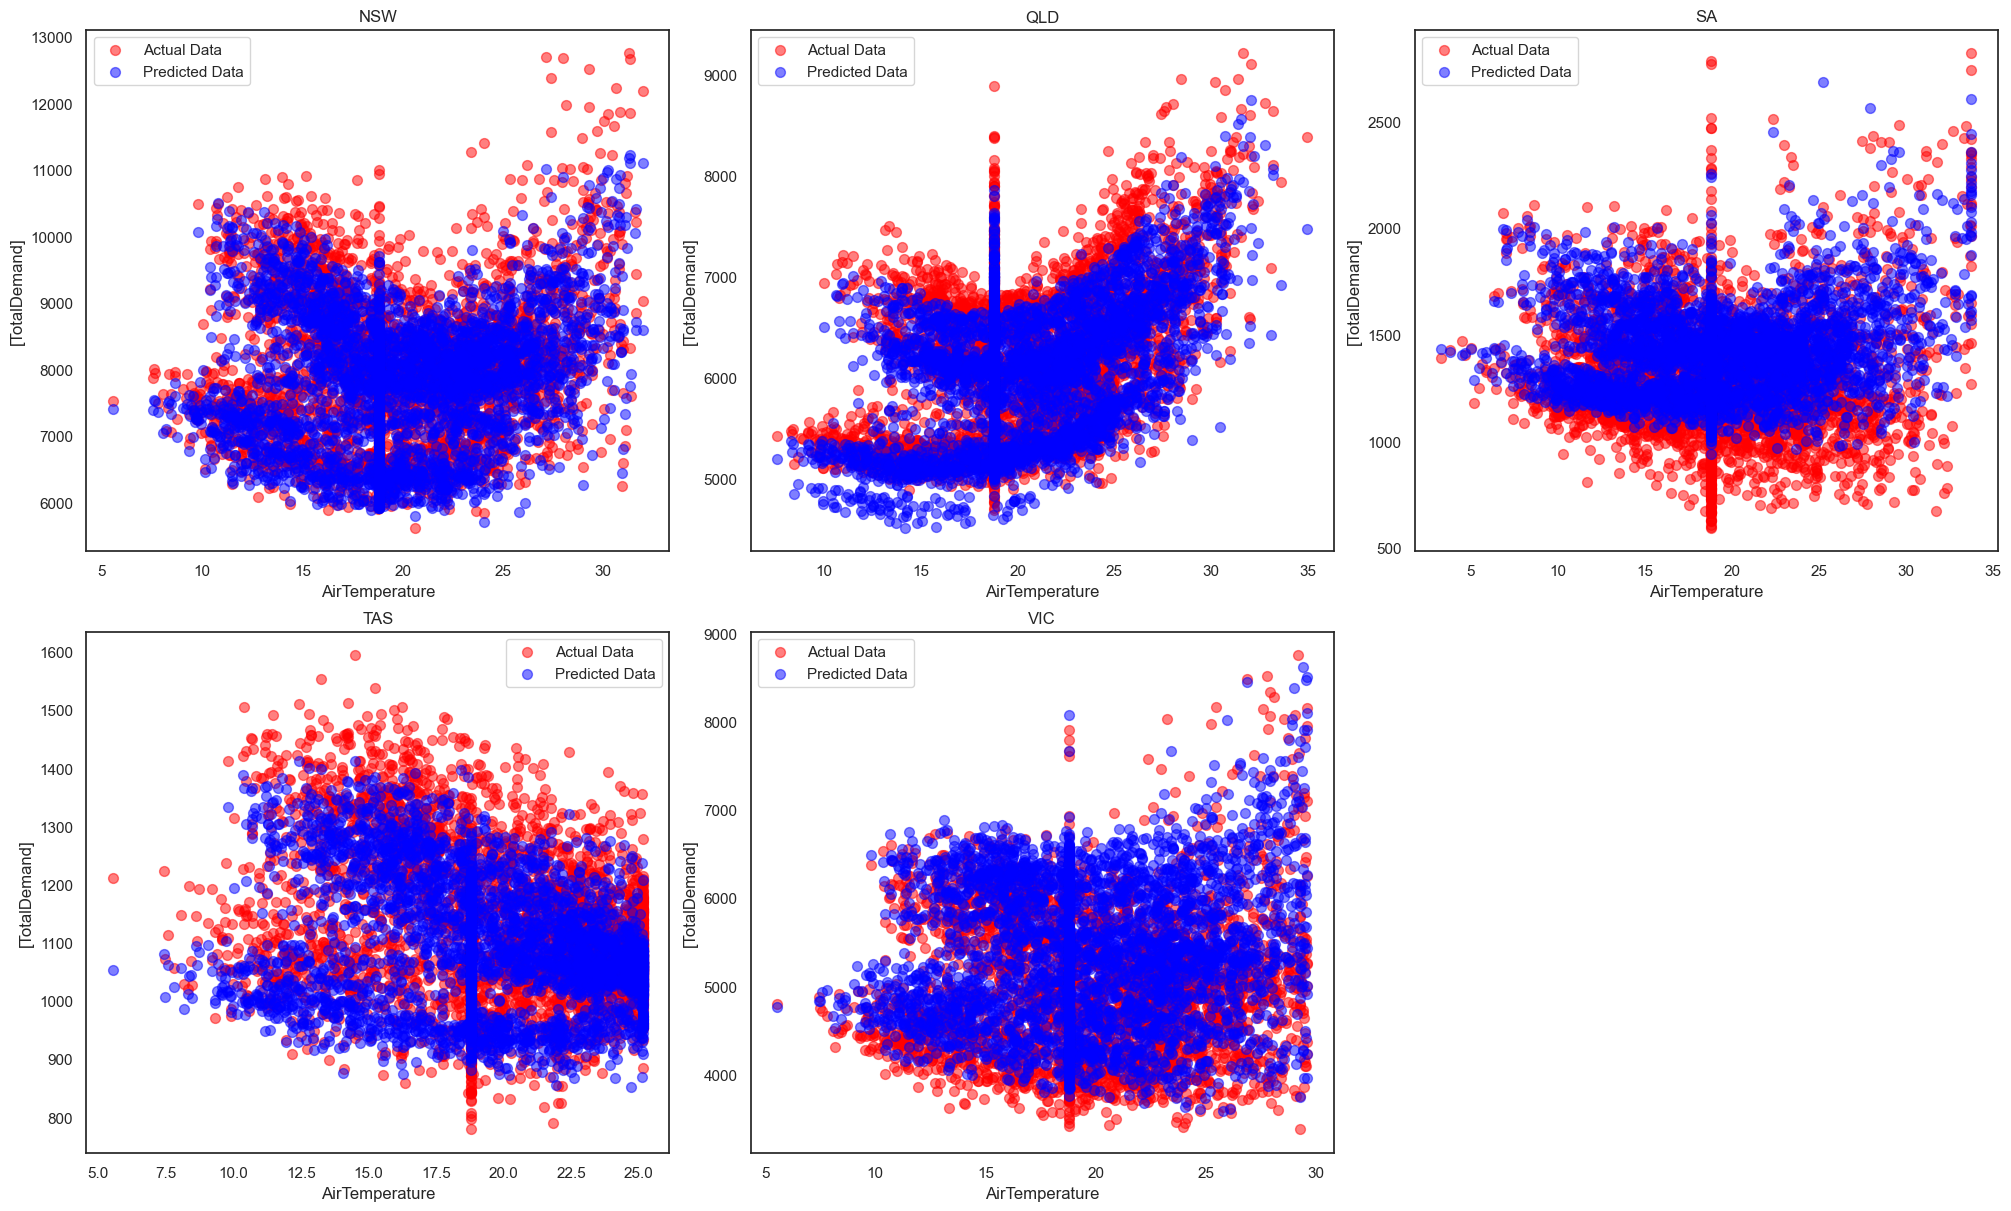

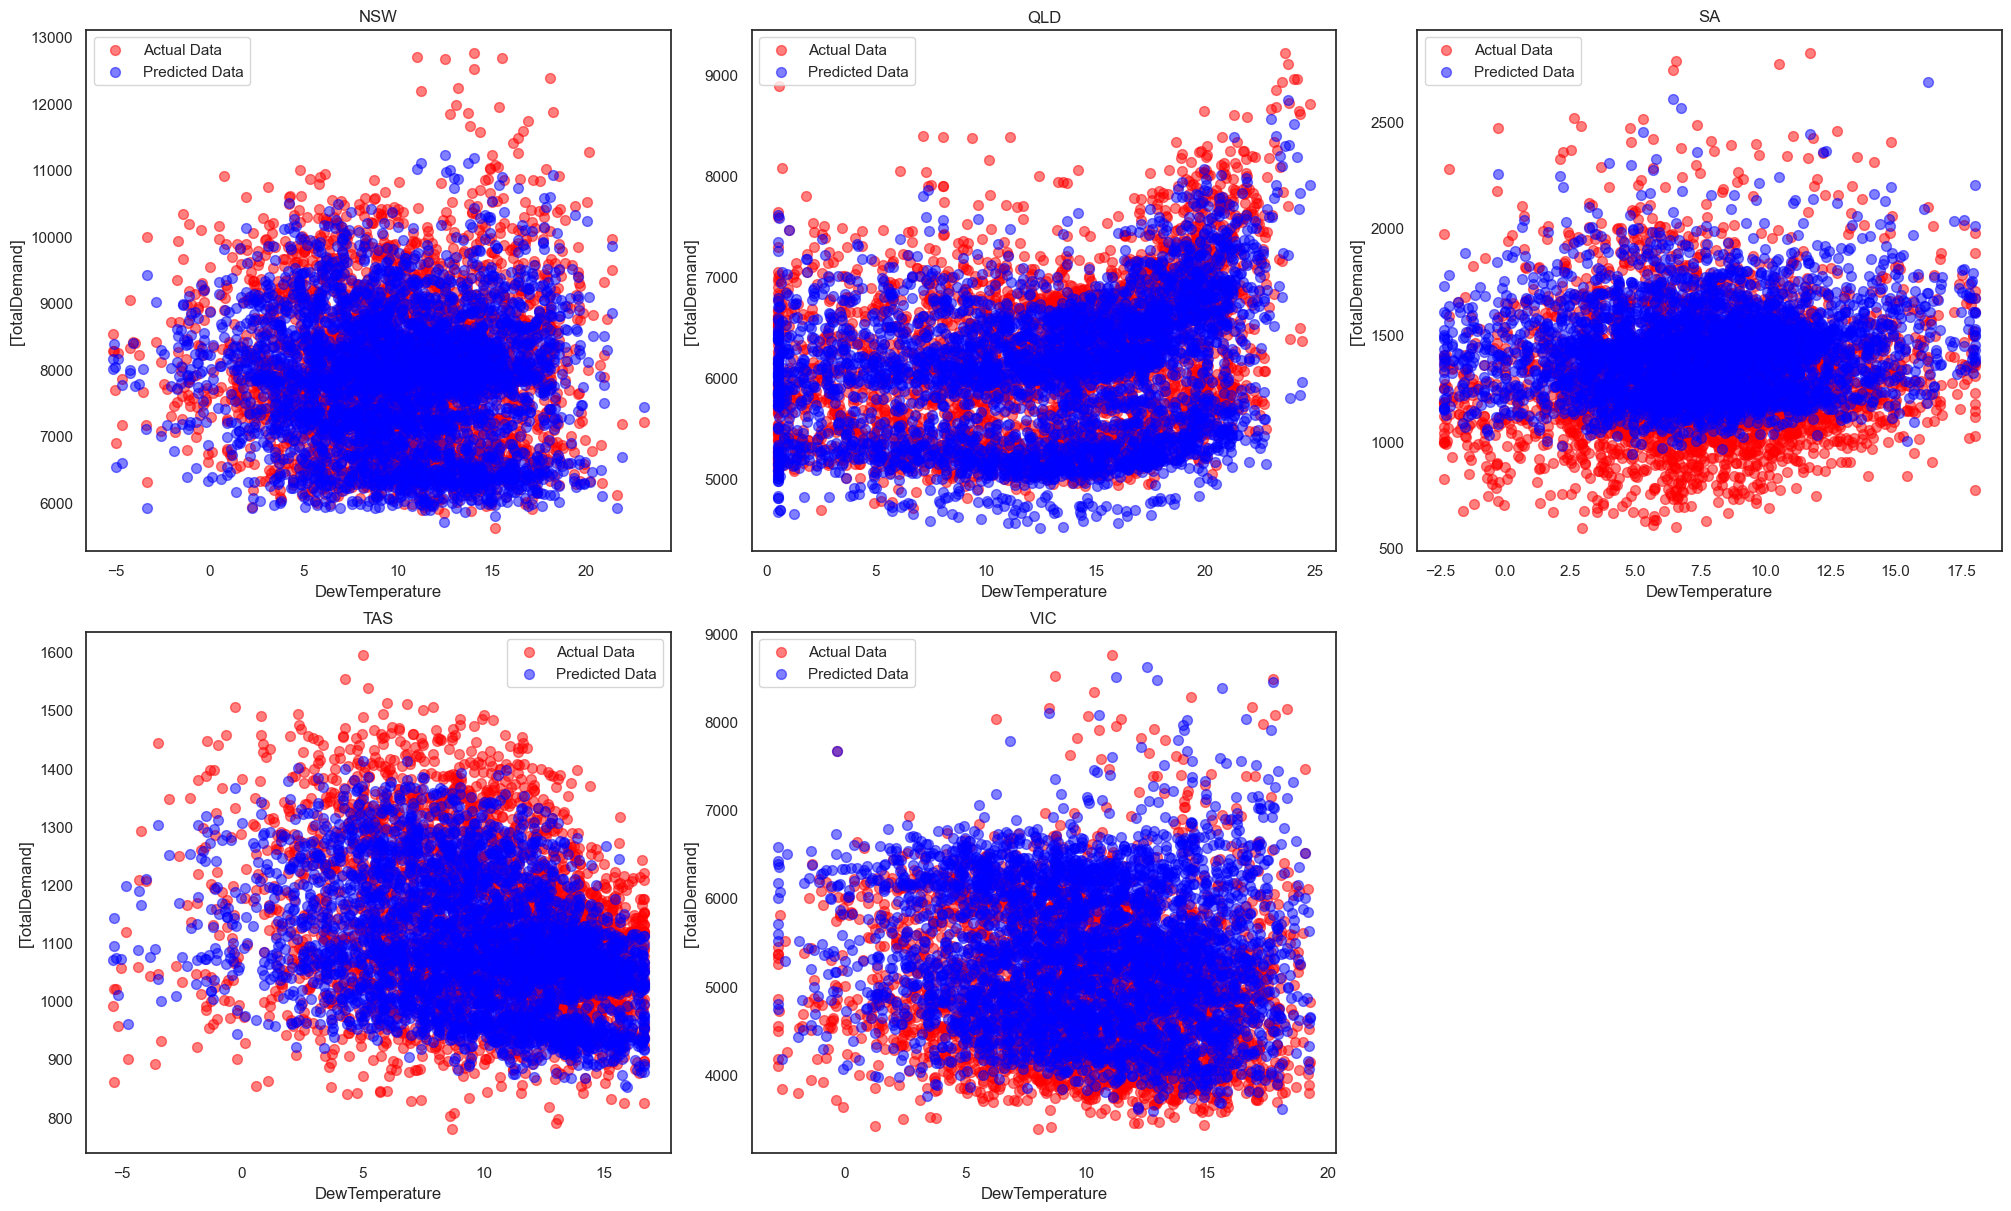

In [8]:
wetbulb_temperature_actual_predicted_scatter(test_data, test_predictions, output_columns);
air_temperature_actual_predicted_scatter(test_data, test_predictions, output_columns);
dewpoint_temperature_actual_predicted_scatter(test_data, test_predictions, output_columns);

Red markers represent actual data, whereas blue markers indicate the model's predicted values. While the model generally performs well, there are notable differences between predicted and actual values, indicating that it is not flawless. Continuous modification and optimization of the model may address the above discrepancies, and improve the model's prediction capabilities even further. Despite these discrepancies, the model's accuracy remains commendable. Regions like Tasmania and Queensland show out as particularly well-predicted, which is likely contributing to their relatively high-performance scores.


Moving on to the visualization of predicted and actual values of energy demand time series based on testing data for each region to assess the model's fit and performance.

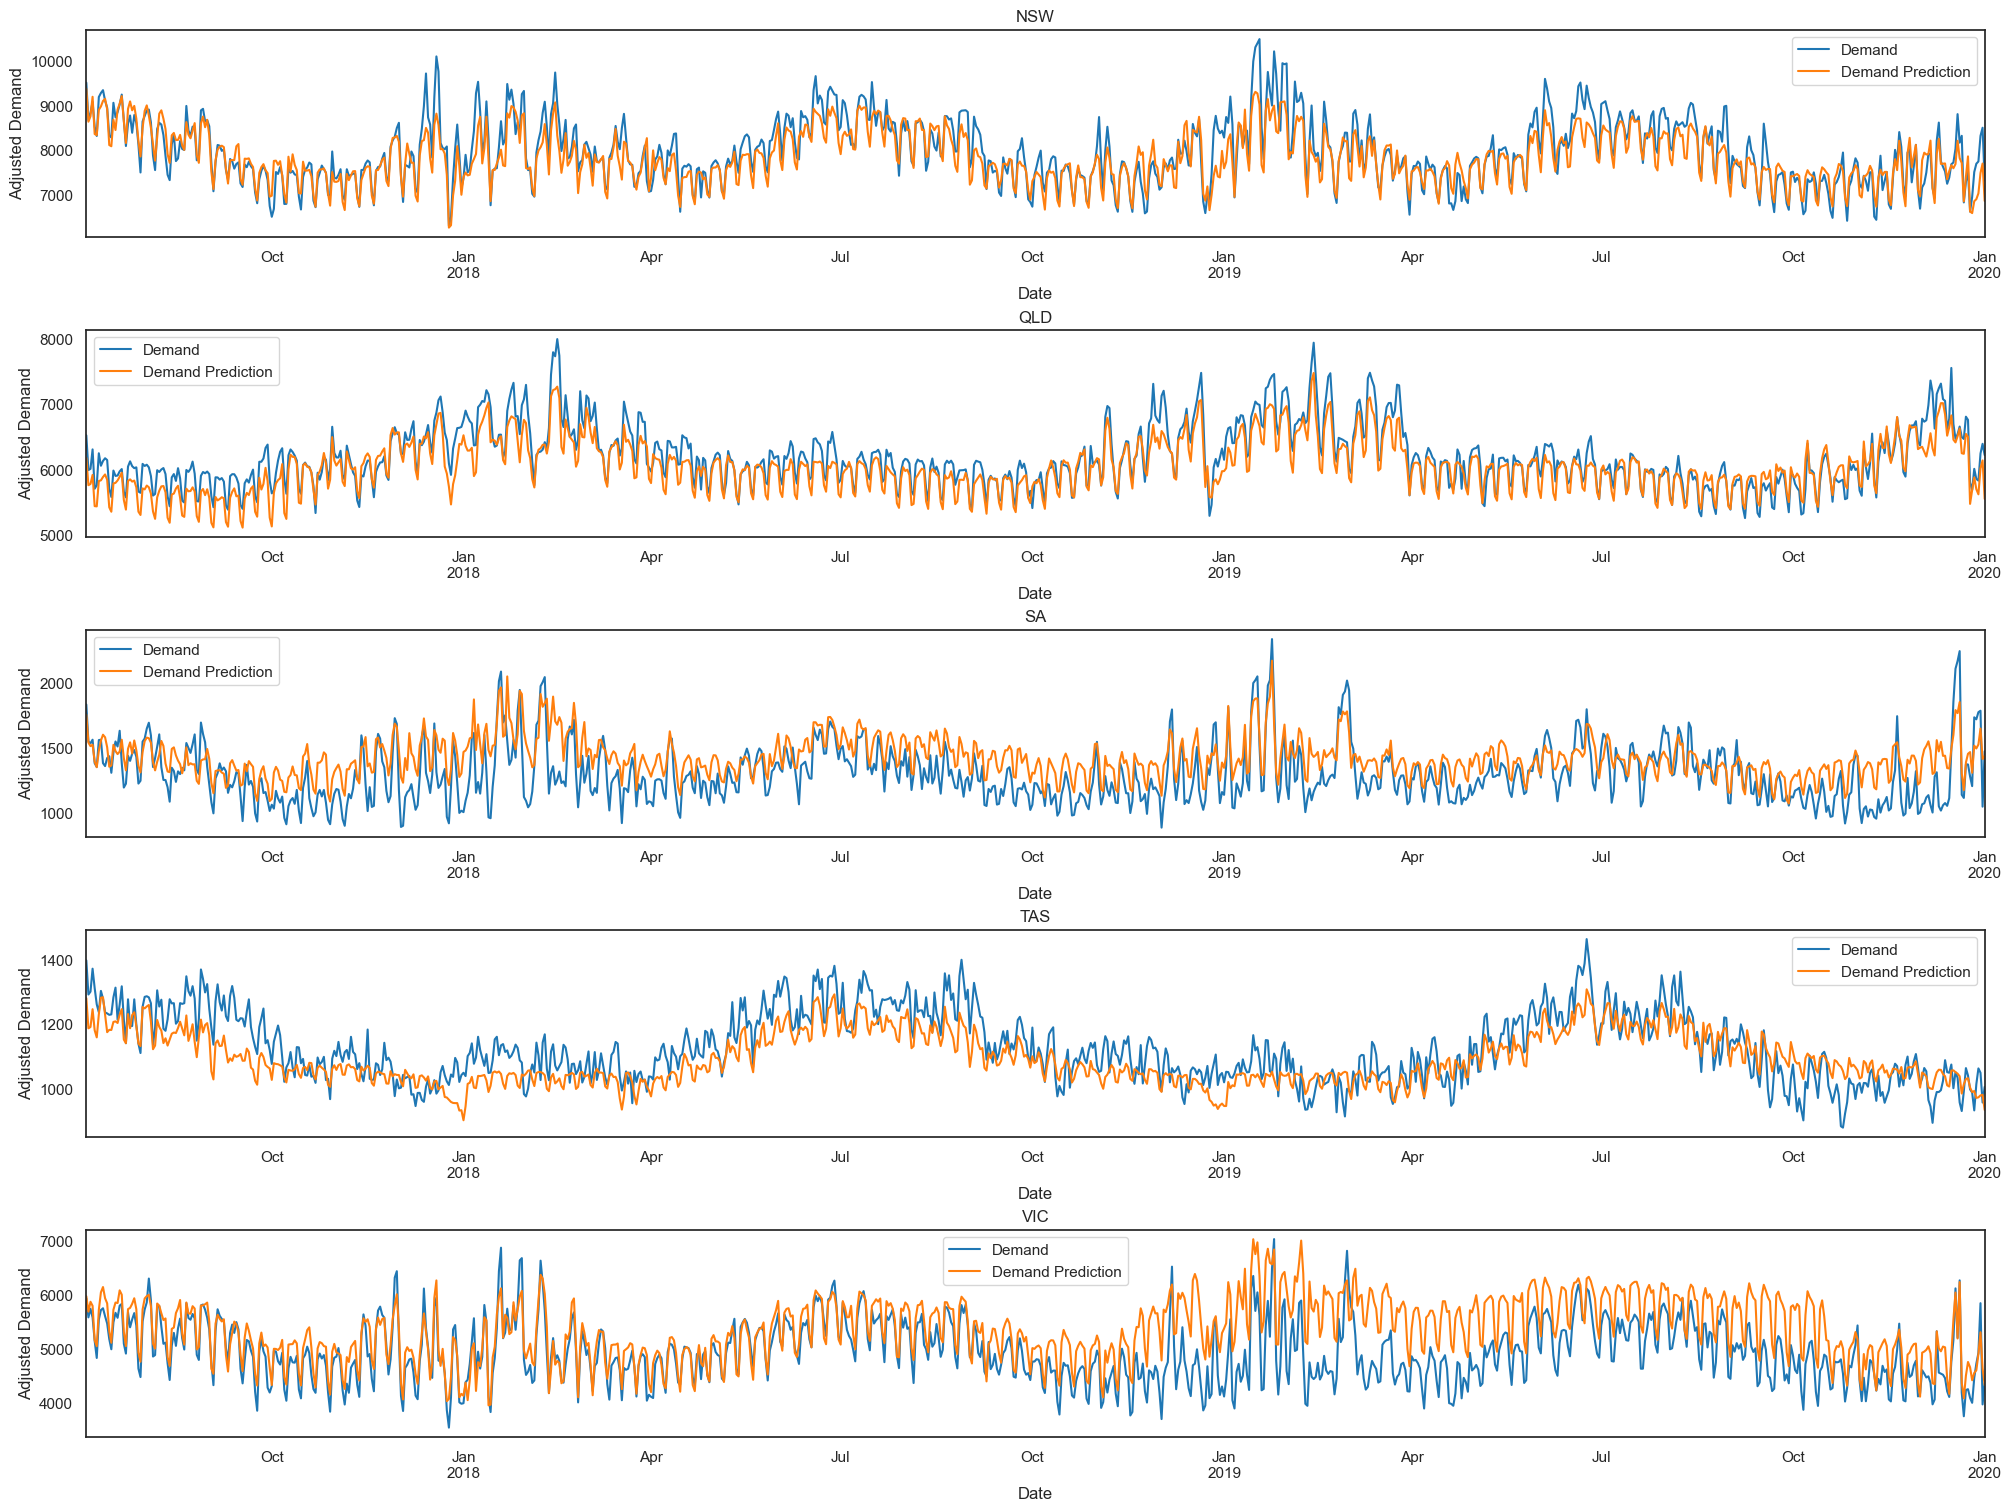

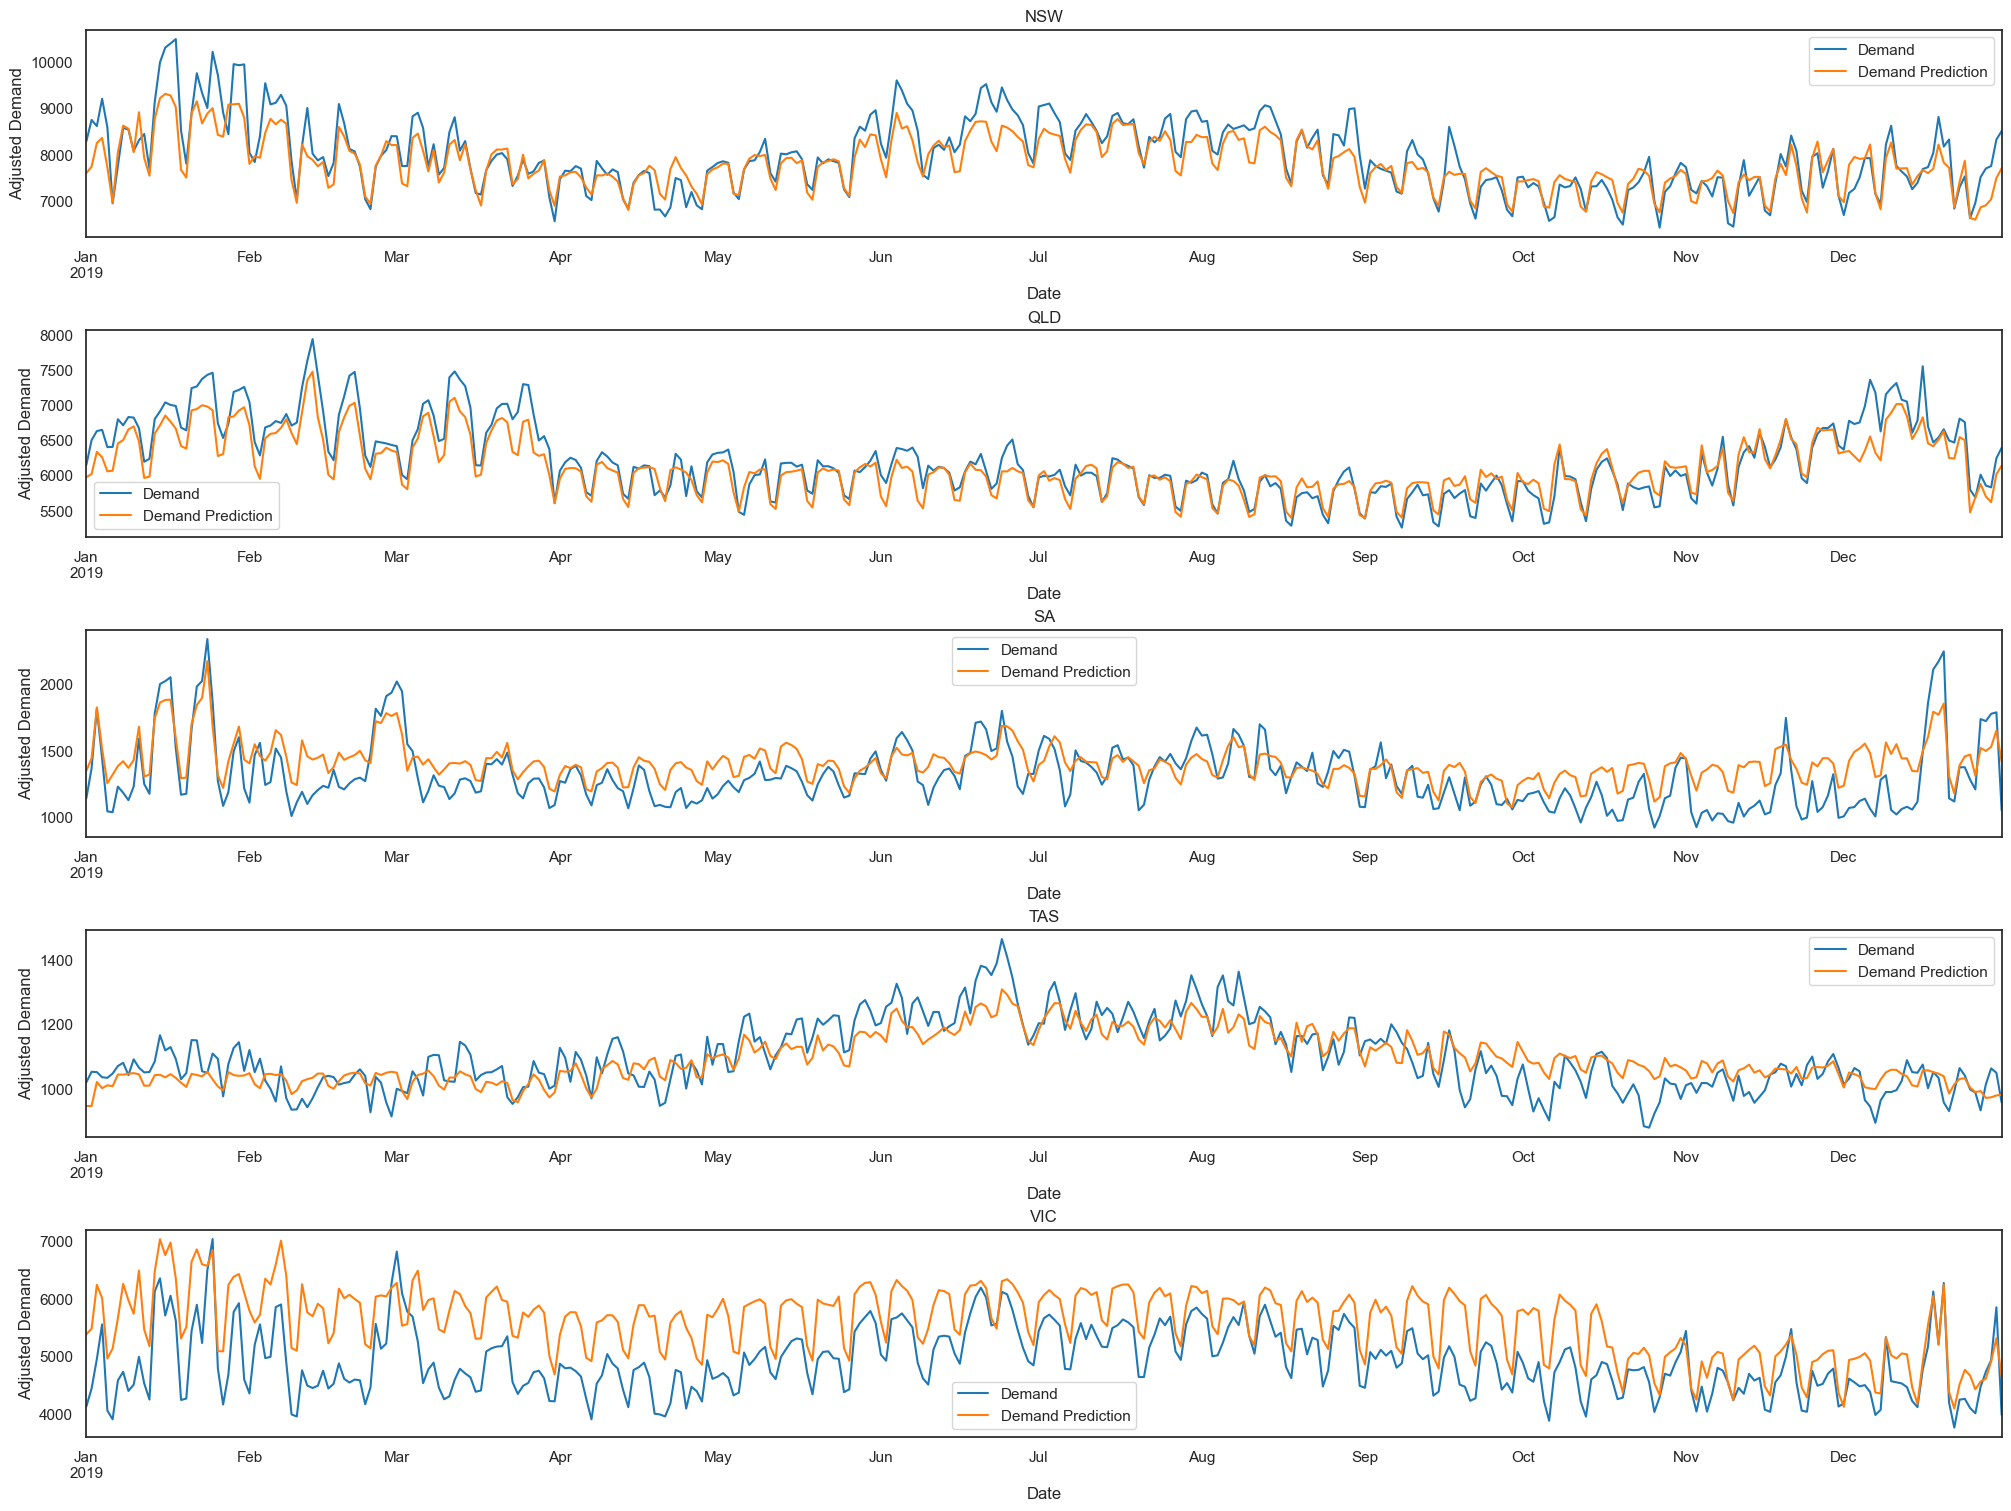

In [9]:
actual_predicted_demand_line_plot(test_data, test_predictions, output_columns);
actual_predicted_2019_demand_line_plot(test_data, test_predictions, output_columns);

It can be observed that the graph captures the general trends of ups and downs in energy demand over time; however, there are instances of deviation between predicted and actual values, particularly during periods of high variability or unforeseen events.

The overall alignment between the two implies that the model is robust and capable of accurately capturing the dynamic nature of energy demand across different regions with considerable accuracy. 


### Calculating Feature Importance

Feature importance is a fundamental concept in machine learning that measures the relative contribution of input variables, or features, to predicting the target outcome. Evaluating feature importance assists in understanding the underlying patterns and relationships in the data, as well as identifying the major factors influencing the target variable's variability. Also, it aids model optimization by identifying areas where feature engineering or data preprocessing could be useful. The graphs below depict the feature importance for each region, highlighting the major predictors that contribute to the model's performance. These scores are normalized and presented as percentages.

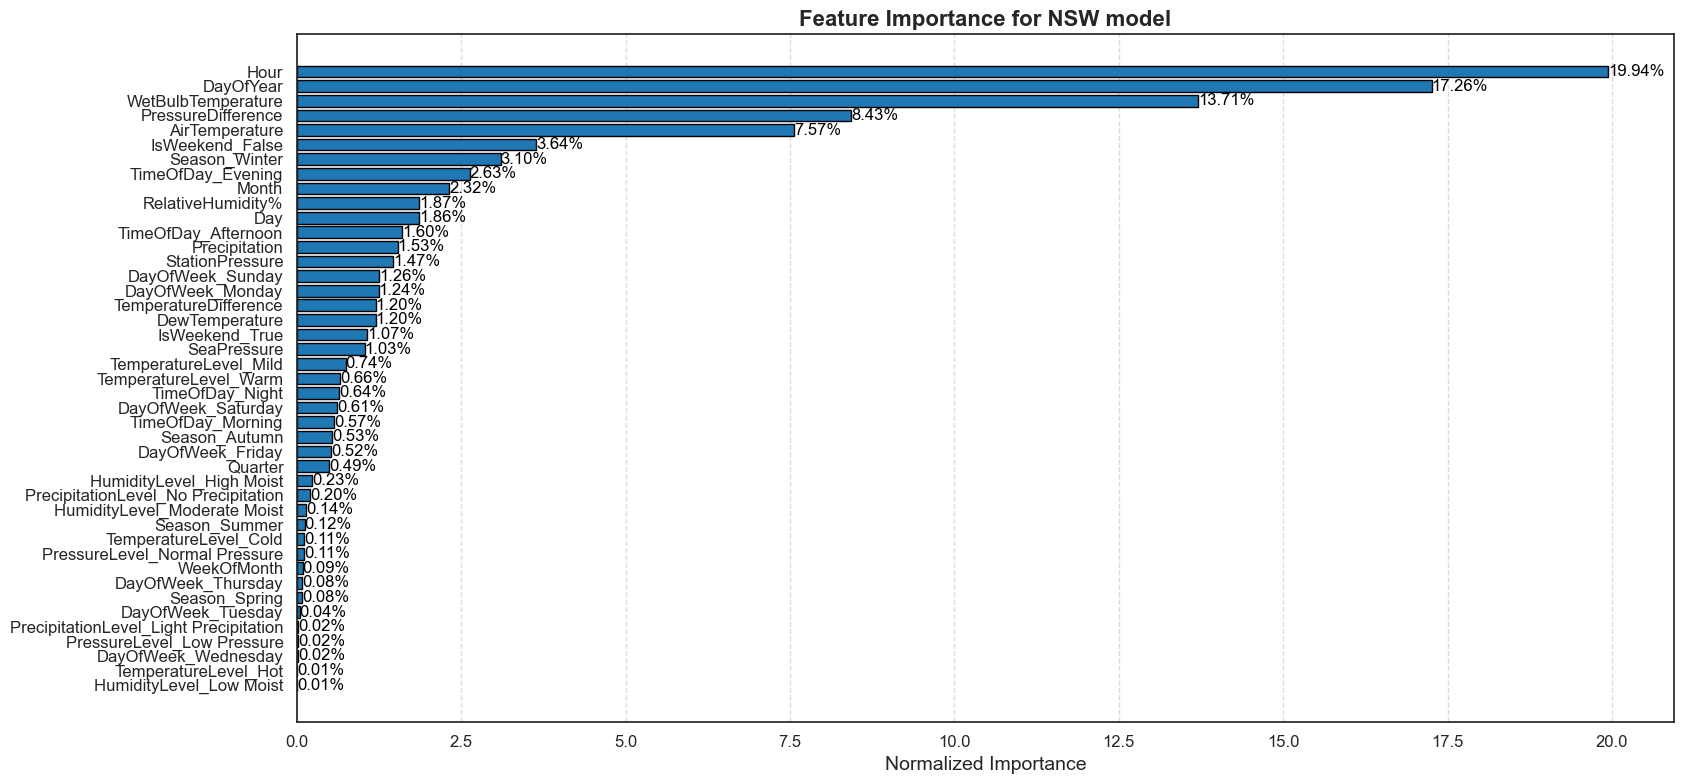

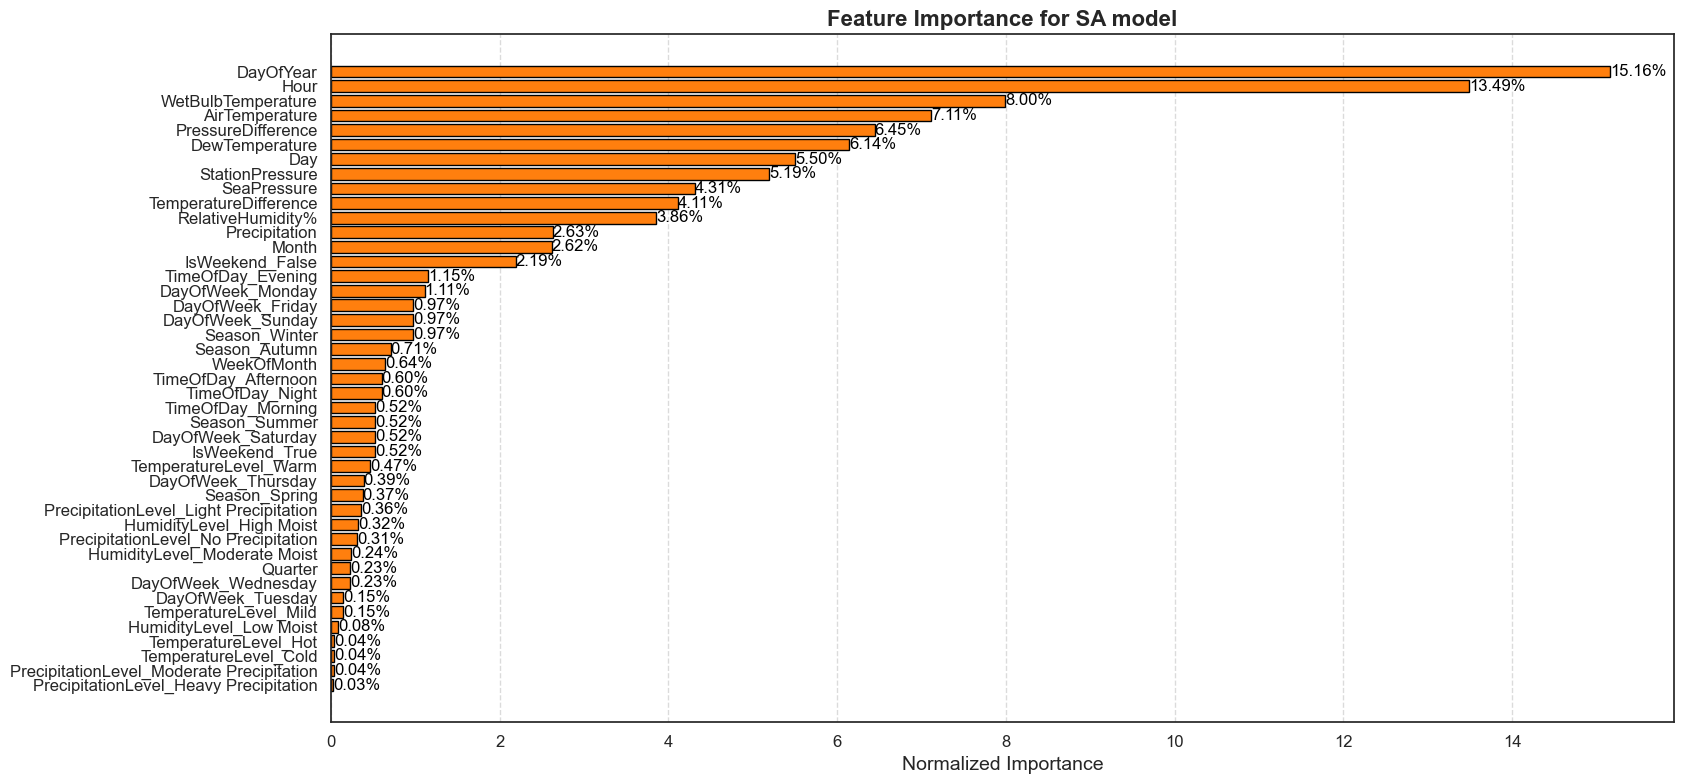

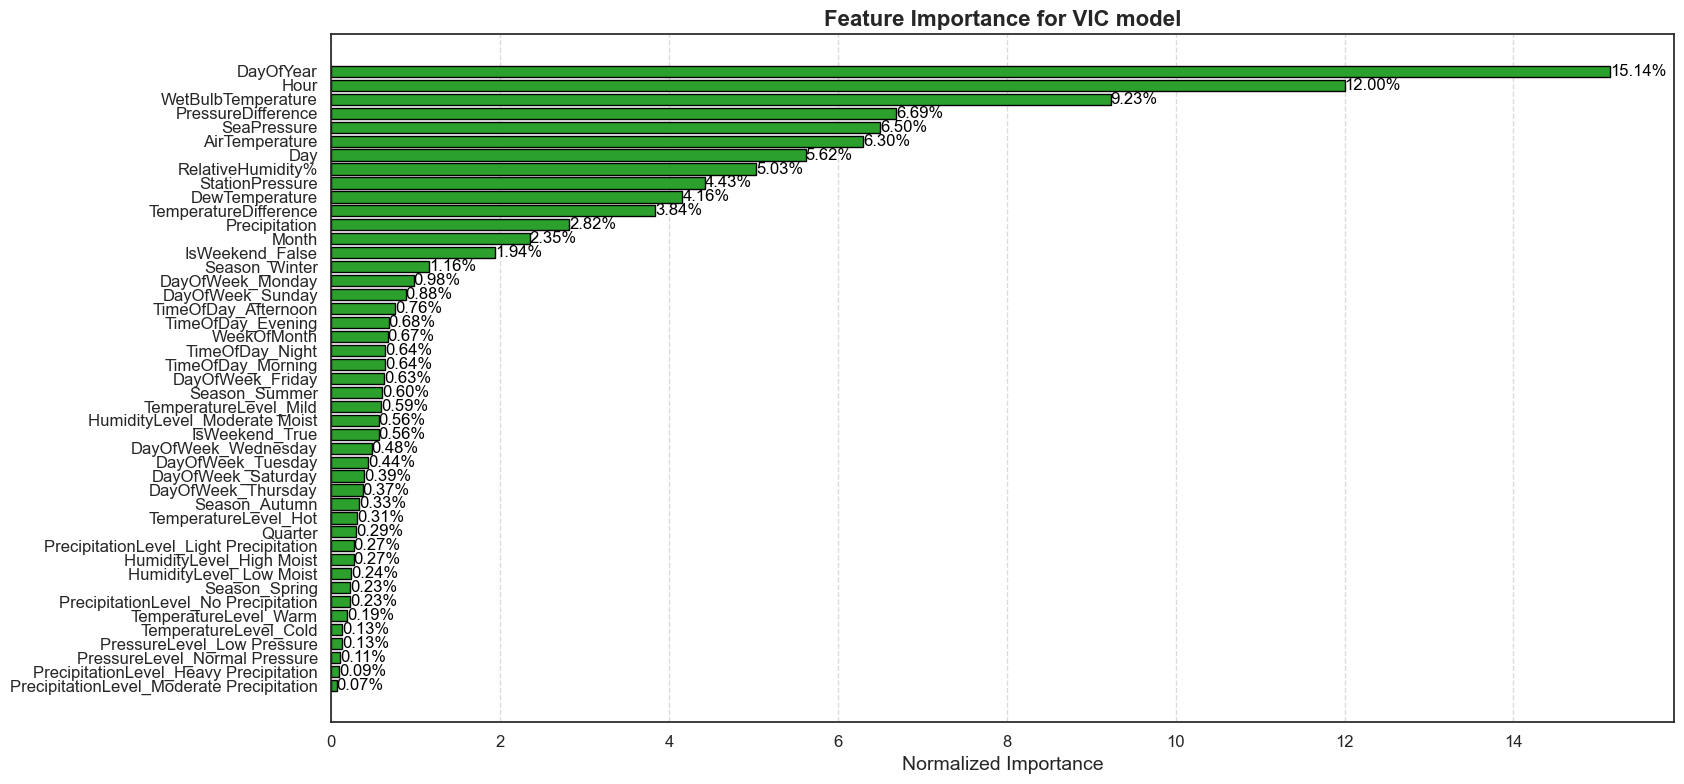

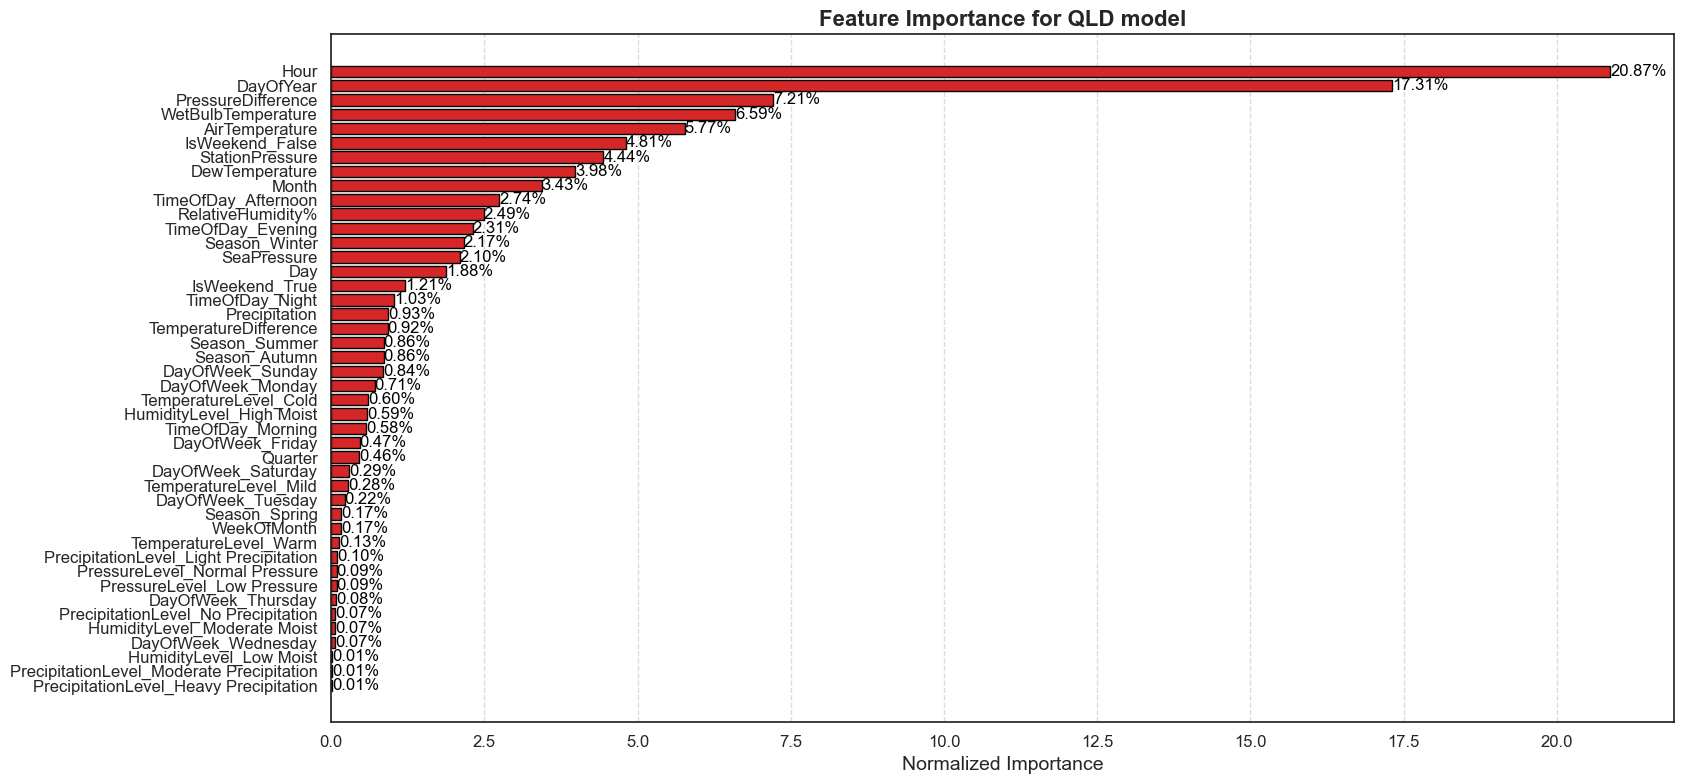

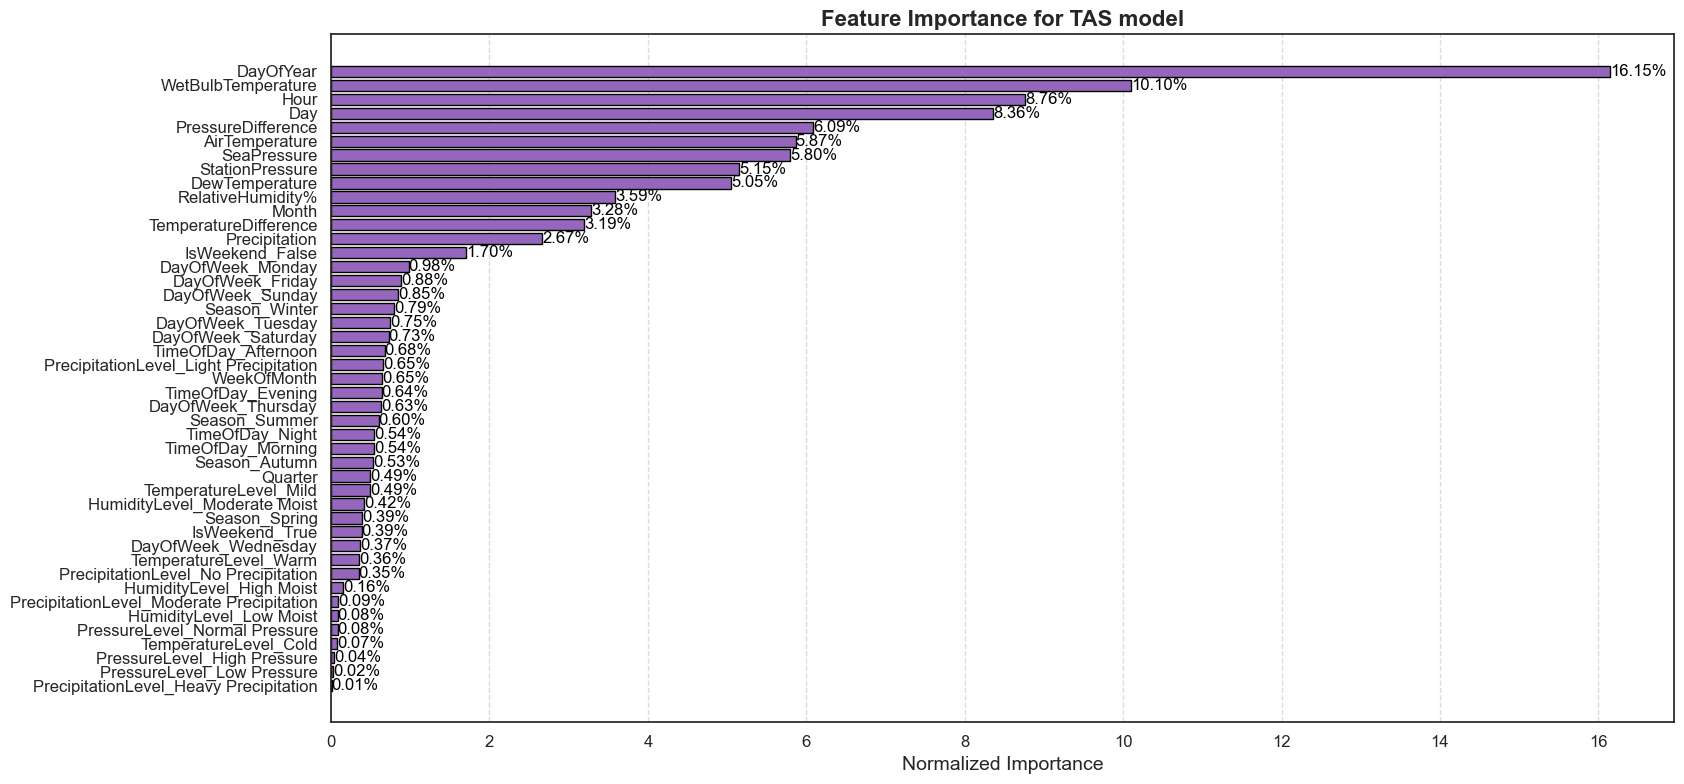

In [10]:
feature_importance_regional_bar_plot(regressors, train_data, input_columns);

Feature Importance of Temporal and Seasonal Parameters
Across all regions, the most influential temporal and seasonal features, based on the above feature importance scores, are:

•	Hour: appears to be consistently significant across all regions, which indicates the daily consumption cycle and its impact on energy usage.

•	DayOfYear: Similarly, the specific day in the annual calendar is also one of the top features across all regions' models.

•	Day: the specific day of the month, which appears to have a moderate level of importance across the regions.

•	Month: the month of the year appears to be relevant across all regions, capturing seasonal trends.

•	TimeOfDay_Afternoon and TimeOfDay_Night: represent the afternoon time and the nighttime periods, which consistently emerge as influential, possibly indicating peak usage hours during the day. The TimeOfDay column assigns each hour of the day into one of the four categories: 'Morning: 5–11 (inclusive)', 'Afternoon: 12–16 (inclusive)', 'Evening: 17–20 (inclusive)', or 'Night: 21–4 (inclusive).

•	Season_Winter and Season_Summer: represent the specific seasonal variables that are important in the models, implying that energy demand is influenced by the particular conditions associated with each season. The Season column is categorized based on the common division of the year into four seasons: Summer, Winter, Autumn, and Spring.

•	IsWeekend_False: indicates whether a specific day is a weekday, which commonly has different energy consumption patterns than weekends due to the energy-consuming activities that occur more frequently on weekdays.


###  Feature Importance for Weather Parameters

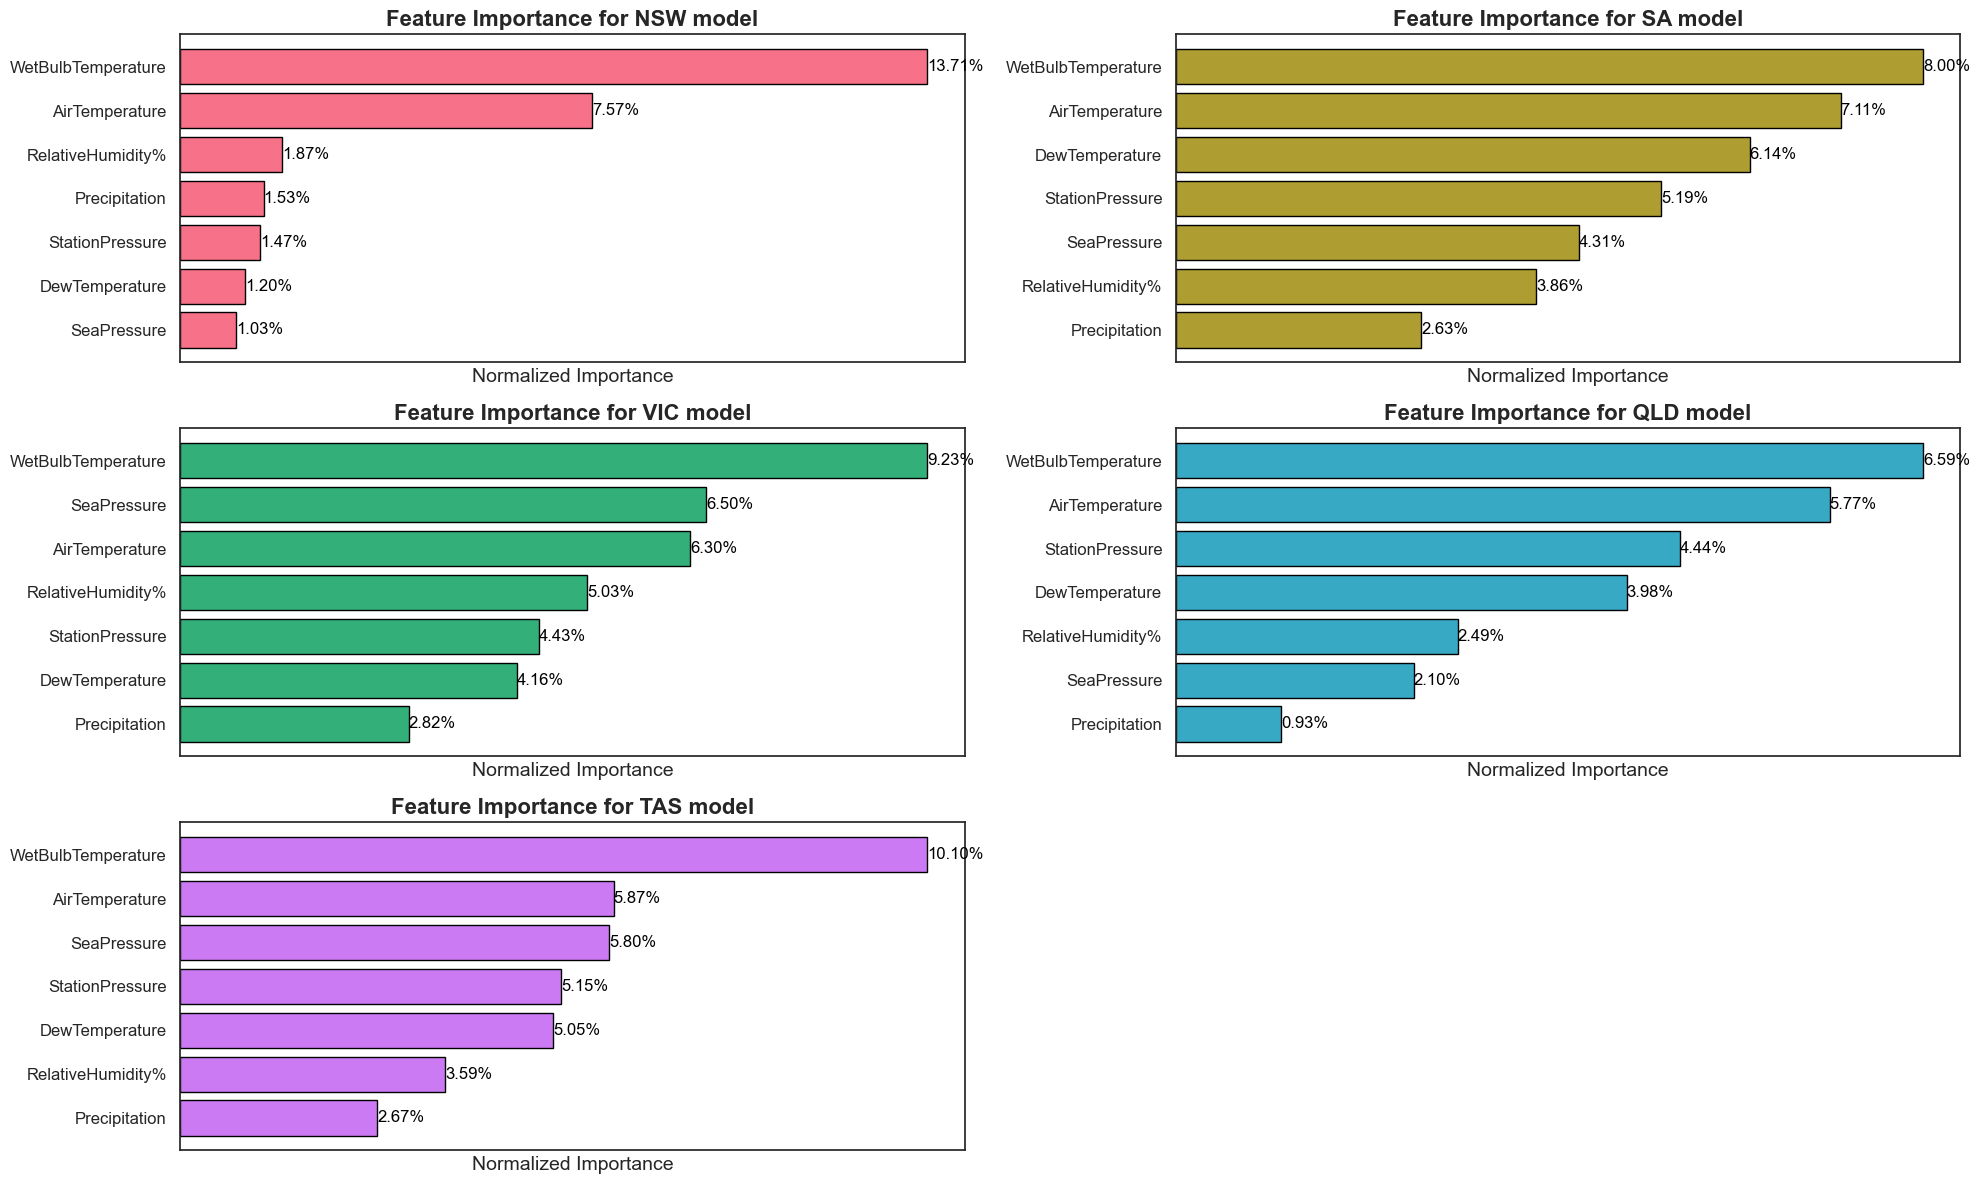

In [11]:
weather_feature_importance_regional_bar_plot(regressors, train_data, input_columns, selected_features);

The feature importance interpretation for specified weather parameters across all five regions is as follows:

Wet Bulb Temperature: has consistently emerged as the most important weather characteristic at all sites. Wet bulb temperature evaluates the combined effects of temperature and humidity, making it a reliable indication of environmental factors that directly affect energy usage. Its importance highlights the need to evaluate not just the heat but also how the heat feels when combined with humidity, which is particularly significant in climates where the human body's cooling through perspiration is involved.

Air Temperature: consistently has significant importance, though less so than wet bulb temperature. Its direct impact on heating and cooling requirements makes it a key predictor of energy demand. Higher temperatures typically result in higher cooling demand, particularly in warmer climates, whereas lower temperatures increase heating requirements.
Dew Point Temperature: represents moisture levels in the atmosphere, is relatively less important across the board. It indicates that, while it is a factor worth considering, it is not as significant as other temperature measurements in the models.

Precipitation: is the least significant weather parameter. Though its presence in all models suggests that rainfall and other forms of precipitation have a role in influencing outdoor conditions, perhaps due to their impact on temperature and humidity or because they may indirectly influence energy consumption patterns.

Relative Humidity: has a range of influences among regions, with Victoria being of notable significance. Humidity affects both human comfort and the functionality of heating and cooling systems, which in turn impacts energy usage. Higher humidity levels can cause temperatures to feel cooler in the winter and warmer in the summer, increasing heating and cooling requirements.

Station Pressure and Sea Pressure: both have moderate importance across regions, exerting a considerable impact in Victoria. These results indicate that atmospheric pressure changes are secondary to temperature-related parameters. Pressure may impact weather systems, hence affecting energy demand via variations in temperature and weather conditions. Moreover, the pressure difference between sea pressure (Mean Sea Level Pressure) and station pressure has substantial importance among all locations. Because the pressure differential determines wind speed and direction, wind patterns impact the regulation of temperatures and may influence heating and cooling needs.


---